# L layered Deep Neural Network

# Packages

In [34]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt

# Model 

![img](images/deep_network.png)

# Dataset

In [35]:
X_train = np.loadtxt('cat_train_x.csv', delimiter = ',')/255.0
Y_train = np.loadtxt('cat_train_y.csv', delimiter = ',').reshape(1, X_train.shape[1])
X_test = np.loadtxt('cat_test_x.csv', delimiter = ',')/255.0
Y_test = np.loadtxt('cat_test_y.csv', delimiter = ',').reshape(1, X_test.shape[1])


print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(12288, 209)
(1, 209)
(12288, 50)
(1, 50)


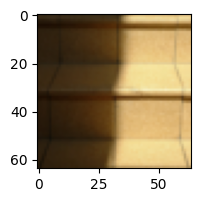

In [36]:
index = random.randrange(0, X_train.shape[1])
plt.figure(figsize=(2, 2))
plt.imshow(X_train[:, index].reshape(64,64, 3))
plt.show()

# Activation Functions

In [37]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return A

def softmax(z):
    expZ = np.exp(z)
    return expZ/(np.sum(expZ, 0))

def relu(Z):
    A = np.maximum(0,Z)
    return A

def tanh(x):
    return np.tanh(x)

def derivative_relu(Z):
    return np.array(Z > 0, dtype = 'float')

def derivative_tanh(x):
    return (1 - np.power(tanh(x), 2))

# Initialize Parameters

- We need to initialize the **W** parameters randomly, and **B** with zeros
- And as our Deep Neural network has **L layers**, we will repeat it for **L-1 times**, from $W_1 to W_L$

<img src="images/params.png" width="350"/>

In [38]:
def initialize_parameters(layer_dims):
    
    parameters = {}
    L = len(layer_dims)            

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

In [39]:
layer_dims = [X_train.shape[0], 100, 200, Y_train.shape[0]]
params = initialize_parameters(layer_dims)

for l in range(1, len(layer_dims)):
    print("Shape of W" + str(l) + ":", params['W' + str(l)].shape)
    print("Shape of B" + str(l) + ":", params['b' + str(l)].shape, "\n")

Shape of W1: (100, 12288)
Shape of B1: (100, 1) 

Shape of W2: (200, 100)
Shape of B2: (200, 1) 

Shape of W3: (1, 200)
Shape of B3: (1, 1) 



#### Expected :

Shape of W1: (100, 12288)

Shape of B1: (100, 1) 

Shape of W2: (200, 100)

Shape of B2: (200, 1) 

Shape of W3: (1, 200)

Shape of B3: (1, 1)

# Forward Propagation

- sigmoid activation function will be used only at the last layer (output layer), while we will use relu/tanh for other layers

<img src="images/forward_prop.png" width="300"/>
 

For f(x), you can use either tanh or ReLU activation function. But also use the derivative of the same for Backpropagation as well

In [40]:
def forward_propagation(X, parameters, activation):
   
    forward_cache = {}
    L = len(parameters) // 2                  
    
    forward_cache['A0'] = X

    for l in range(1, L):
        forward_cache['Z' + str(l)] = parameters['W' + str(l)].dot(forward_cache['A' + str(l-1)]) + parameters['b' + str(l)]
        
        if activation == 'tanh':
            forward_cache['A' + str(l)] = tanh(forward_cache['Z' + str(l)])
        else:
            forward_cache['A' + str(l)] = relu(forward_cache['Z' + str(l)])
            

    forward_cache['Z' + str(L)] = parameters['W' + str(L)].dot(forward_cache['A' + str(L-1)]) + parameters['b' + str(L)]
    
    if forward_cache['Z' + str(L)].shape[0] == 1:
        forward_cache['A' + str(L)] = sigmoid(forward_cache['Z' + str(L)])
    else :
        forward_cache['A' + str(L)] = softmax(forward_cache['Z' + str(L)])
    
    return forward_cache['A' + str(L)], forward_cache

In [41]:
aL, forw_cache = forward_propagation(X_train, params, 'relu')

for l in range(len(params)//2 + 1):
    print("Shape of A" + str(l) + " :", forw_cache['A' + str(l)].shape)

Shape of A0 : (12288, 209)
Shape of A1 : (100, 209)
Shape of A2 : (200, 209)
Shape of A3 : (1, 209)


#### Expected :

Shape of A0 : (12288, 209)

Shape of A1 : (100, 209)

Shape of A2 : (200, 209)

Shape of A3 : (1, 209)

# Cost Function

#### For binary classification:
$ Cost = - \frac{1}{m} \sum_{i=1}^{m} [ y*log(a_L) + (1-y)*log(1 - a_L) ] $

#### For multi-class classification:

$ Cost = - \frac{1}{m} \sum_{i=1}^{m} \sum_{i=k}^{n}[ y_k*log(a_k) ]$

In [42]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    
    if Y.shape[0] == 1:
        cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    else:
        cost = -(1./m) * np.sum(Y * np.log(AL))
        
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    
    return cost

# Backward Propagation

- For last layer, **$dZ_L$** will be $A_L - Y$
- Except for last layer, we use a loop to implement backprop for other layers

<img src="images/backward_prop.png" width="300"/>

In [43]:
def backward_propagation(AL, Y, parameters, forward_cache, activation):
    
    grads = {}
    L = len(parameters)//2
    m = AL.shape[1]
    
    grads["dZ" + str(L)] = AL - Y
    grads["dW" + str(L)] = 1./m * np.dot(grads["dZ" + str(L)],forward_cache['A' + str(L-1)].T)
    grads["db" + str(L)] = 1./m * np.sum(grads["dZ" + str(L)], axis = 1, keepdims = True)
    
    for l in reversed(range(1, L)):
        if activation == 'tanh':
            grads["dZ" + str(l)] = np.dot(parameters['W' + str(l+1)].T,grads["dZ" + str(l+1)])*derivative_tanh(forward_cache['A' + str(l)])
        else:
            grads["dZ" + str(l)] = np.dot(parameters['W' + str(l+1)].T,grads["dZ" + str(l+1)])*derivative_relu(forward_cache['A' + str(l)])
            
        grads["dW" + str(l)] = 1./m * np.dot(grads["dZ" + str(l)],forward_cache['A' + str(l-1)].T)
        grads["db" + str(l)] = 1./m * np.sum(grads["dZ" + str(l)], axis = 1, keepdims = True)

    return grads

In [44]:
grads = backward_propagation(forw_cache["A" + str(3)], Y_train, params, forw_cache, 'relu')

for l in reversed(range(1, len(grads)//3 + 1)):
    print("Shape of dZ" + str(l) + " :", grads['dZ' + str(l)].shape)
    print("Shape of dW" + str(l) + " :", grads['dW' + str(l)].shape)
    print("Shape of dB" + str(l) + " :", grads['db' + str(l)].shape, "\n")

Shape of dZ3 : (1, 209)
Shape of dW3 : (1, 200)
Shape of dB3 : (1, 1) 

Shape of dZ2 : (200, 209)
Shape of dW2 : (200, 100)
Shape of dB2 : (200, 1) 

Shape of dZ1 : (100, 209)
Shape of dW1 : (100, 12288)
Shape of dB1 : (100, 1) 



#### Expected Output

Shape of dZ3 : (1, 209)

Shape of dW3 : (1, 200)

Shape of dB3 : (1, 1) 

Shape of dZ2 : (200, 209)

Shape of dW2 : (200, 100)

Shape of dB2 : (200, 1) 

Shape of dZ1 : (100, 209)

Shape of dW1 : (100, 12288)

Shape of dB1 : (100, 1) 

# Update Parameters
<img src="images/update_params.png" width="300"/>

In [45]:
def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2 
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

# Predictions

In [46]:
def predict(X, y, parameters, activation):

    m = X.shape[1]
    y_pred, caches = forward_propagation(X, parameters, activation)
    
    if y.shape[0] == 1:
        y_pred = np.array(y_pred > 0.5, dtype = 'float')
    else:
        y = np.argmax(y, 0)
        y_pred = np.argmax(y_pred, 0)
    
    return np.round(np.sum((y_pred == y)/m), 2)

# Complete Model

Implement the entire Deep Neural Network here

### Instructions :

We need to initialize parameters once, and after that, we will run the following in a loop:
- forward_prop(x, parameters)
- cost_function(aL, y)
- backward_prop(x, y, parameters, forward_cache)
- parameters = update_parameters(parameters, gradients, learning_rate)

### Return :
- parameters, which will be our trained parameters

In [47]:
def model(X, Y, layers_dims, learning_rate = 0.03, activation = 'relu', num_iterations = 3000):#lr was 0.009

    np.random.seed(1)
    costs = []              
    
    parameters = initialize_parameters(layers_dims)

    for i in range(0, num_iterations):

        AL, forward_cache = forward_propagation(X, parameters, activation)

        cost = compute_cost(AL, Y)

        grads = backward_propagation(AL, Y, parameters, forward_cache, activation)

        parameters = update_parameters(parameters, grads, learning_rate)
        
        if i % (num_iterations/10) == 0:
            print("\niter:{} \t cost: {} \t train_acc:{} \t test_acc:{}".format(i, np.round(cost, 2), predict(X_train, Y_train, parameters, activation), predict(X_test, Y_test, parameters, activation)))
        
        if i % 10 == 0:
            print("==", end = '')

       
    return parameters

In [48]:
layers_dims = [X_train.shape[0], 20, 7, 5, Y_train.shape[0]] #  4-layer model
lr = 0.0075
iters = 2500

parameters = model(X_train, Y_train, layers_dims, learning_rate = lr, activation = 'relu', num_iterations = iters)


iter:0 	 cost: 0.77 	 train_acc:0.51 	 test_acc:0.42
iter:250 	 cost: 0.63 	 train_acc:0.74 	 test_acc:0.64
iter:500 	 cost: 0.54 	 train_acc:0.78 	 test_acc:0.7
iter:750 	 cost: 0.44 	 train_acc:0.92 	 test_acc:0.78
iter:1000 	 cost: 0.32 	 train_acc:0.96 	 test_acc:0.8
iter:1250 	 cost: 0.23 	 train_acc:0.98 	 test_acc:0.76
iter:1500 	 cost: 0.16 	 train_acc:0.98 	 test_acc:0.82
iter:1750 	 cost: 0.13 	 train_acc:0.98 	 test_acc:0.8
iter:2000 	 cost: 0.11 	 train_acc:0.98 	 test_acc:0.8
iter:2250 	 cost: 0.1 	 train_acc:0.98 	 test_acc:0.8

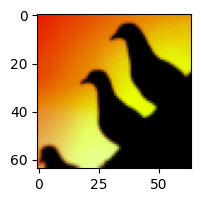

Our model says it is : [0]


In [58]:
idx = int(random.randrange(0, X_test.shape[1]))
plt.figure(figsize=(2, 2))
plt.imshow(X_test[:, idx].reshape(64,64, 3))
plt.show()

yPred, _ = forward_propagation(X_test[:, idx].reshape(X_test[:, idx].shape[0], 1), parameters, 'tanh')
yPred = 1 * np.array(yPred > 0.5)
print("Our model says it is :", yPred[0])

In [56]:
print("Accuracy of Train Dataset", predict(X_train, Y_train, parameters, 'tanh'), "%")
print("Accuracy of Test Dataset", predict(X_test, Y_test, parameters, 'tanh'), "%")

Accuracy of Train Dataset 0.66 %
Accuracy of Test Dataset 0.34 %
